# 2. Model Building and Evaluation

### 0. Imports

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import cv2 as cv
from utils import *
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost

/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Load in Processed Images

In [2]:
cwd = os.getcwd()
data_path = os.path.join(cwd,'standardized_data/Training')

X = []
y = []

for label in os.listdir(data_path):
    for image in os.listdir(os.path.join(data_path,label)):
        image_path = os.path.join(data_path,label,image)
        load_image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        # flatten_image = load_image.flatten()
        X.append(load_image)
        y.append(label)


# Convert to Numpy Array
X = np.array(X)
y = np.array(y)
le = LabelEncoder()
le.fit(y) 
y = le.transform(y)

print(X.shape)
print(y.shape)

print(X[0])
print(y[0])

(5712, 512, 512)
(5712,)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
3


### 2. Base Model (most common class classifier)

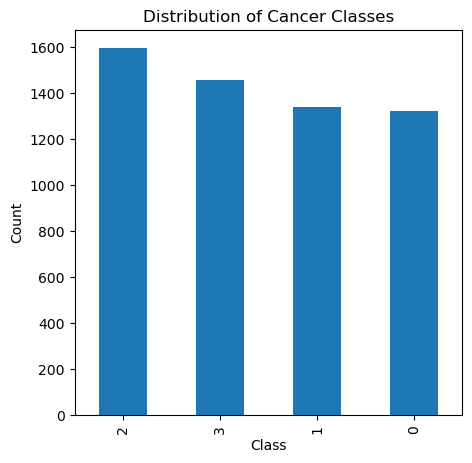

['glioma' 'meningioma' 'notumor' 'pituitary']


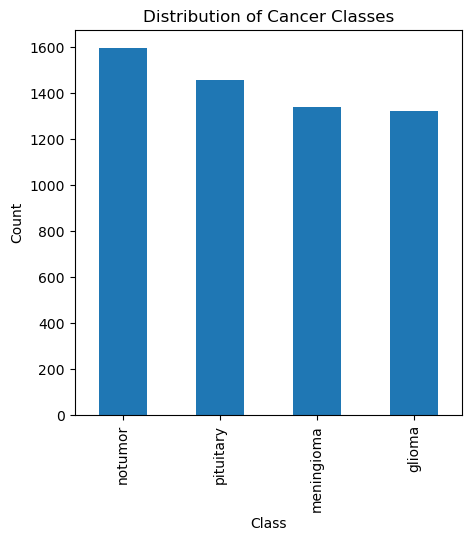

Most Common Label: 2
(5712,)
(5712,)


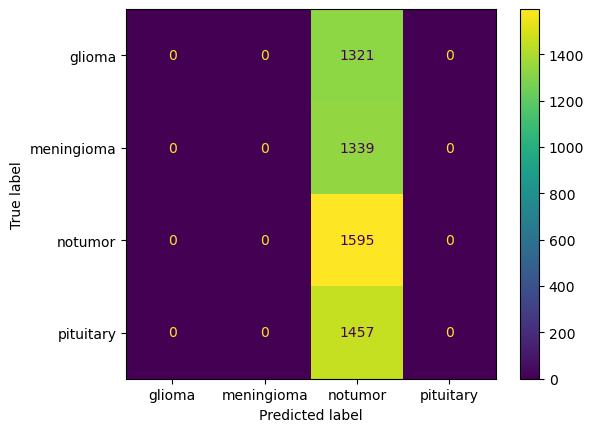

================== TRAINING METRICS ===================
Accuracy Score: 0.27923669467787116
Macro Precision: 0.06980917366946779
Macro Recall: 0.25
Macro F1: 0.10914191870808813
Micro Precision: 0.27923669467787116
Micro Recall: 0.27923669467787116
Micro F1: 0.27923669467787116


/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
plt.figure(figsize=(5,5))
y_train_series = pd.Series(y)
y_train_series.value_counts().plot(kind='bar')
plt.title('Distribution of Cancer Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()
print(le.classes_)
y_transformed = le.inverse_transform(y)

plt.figure(figsize=(5,5))
y_train_series = pd.Series(y_transformed)
y_train_series.value_counts().plot(kind='bar')
plt.title('Distribution of Cancer Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


# Generate Model Statistics
most_common_label = stats.mode(y)[0]
print("Most Common Label: " + str(most_common_label))
y_predict = np.ones((y.shape)) * most_common_label
print(y_predict.shape)
print(y.shape)

# Generate Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = le.classes_)
cm_display.plot()
plt.show()

accuracy_score = metrics.accuracy_score(y, y_predict)
macro_precision = metrics.precision_score(y,y_predict,average ='macro')
macro_recall = metrics.recall_score(y,y_predict,average='macro')
macro_f1 = metrics.f1_score(y,y_predict,average='macro')
micro_precision = metrics.precision_score(y,y_predict,average='micro')
micro_recall = metrics.recall_score(y,y_predict,average='micro')
micro_f1 = metrics.f1_score(y,y_predict,average='micro')

print("================== TRAINING METRICS ===================")
print("Accuracy Score: " + str(accuracy_score))
print("Macro Precision: " + str(macro_precision))
print("Macro Recall: " + str(macro_recall))
print("Macro F1: " + str(macro_f1))
print("Micro Precision: " + str(micro_precision))
print("Micro Recall: " + str(micro_recall))
print("Micro F1: " + str(micro_f1))

### 3. Extract Features (Canny Edges, Difference of Gaussians, Complex Feature)

In [4]:
# ### TBD
# X_dog_features = get_features(X, feat_name='blob_dog')
# X_doh_features = get_features(X, feat_name='blob_doh')
# X_canny_features = get_features(X, feat_name='canny')
# pca = PCA(n_components=1000, svd_solver="randomized", whiten=True).fit(X_canny_features)
# X_pca_canny_features = pca.transform(X_canny_features)
# # X_complex_features = get_features(X, feat_name='complex')

# np.save('X_train_dog_features.npy', X_dog_features)
# np.save('X_train_doh_features.npy', X_doh_features)
# np.save('X_train_pca_canny_features.npy', X_pca_canny_features)
# # np.save('X_train_complex_features.npy', X_complex_features)
# np.save('Y_train.npy',y)
# y_raw_train = le.inverse_transform(y)
# np.save('Y_raw_train.npy',y_raw_train)
# print(y.shape)
# print(y_raw_train.shape)

### 3a. Load Features

In [5]:
X_train_dog_features = np.load('X_train_dog_features.npy')
X_train_doh_features = np.load('X_train_doh_features.npy')
X_train_pca_canny_features = np.load('X_train_pca_canny_features.npy')
y_train = np.load('Y_train.npy')

### 3a. PCA Variance Vectors

In [6]:
# x = plot_PCA([X_dog_features, X_doh_features, X_canny_features, X_complex_features], n_components=[min(X_dog_features.shape), min(X_doh_features.shape), 1000, min(X_complex_features.shape)])


### 4. Shuffle Data

In [7]:
np.random.seed(281)

# Create a list of indexes that is the length of the number of training examples
indices = [i for i in range(0,X.shape[0])]
shuffle_indices = np.random.permutation(indices)

# Reorder X and Y based on the shuffled indices
# X = X[shuffle_indices]
# y = y[shuffle_indices]

X_dog_features = X_train_dog_features[shuffle_indices]
X_doh_features = X_train_doh_features[shuffle_indices]
X_canny_features = X_train_pca_canny_features[shuffle_indices]
# X_complex_features = X_complex_features[shuffle_indices]

y_train = y_train[shuffle_indices]

In [8]:
print(X_dog_features.shape)
print(X_dog_features.shape)
print(X_canny_features.shape)

(5712, 14)
(5712, 14)
(5712, 1000)


### 5. Model Training

/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


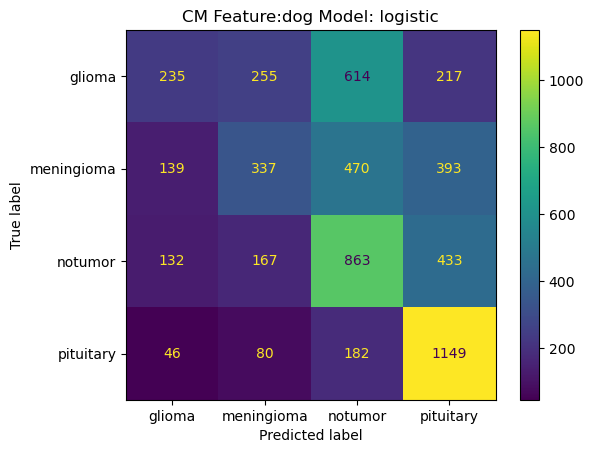

(5712, 4)


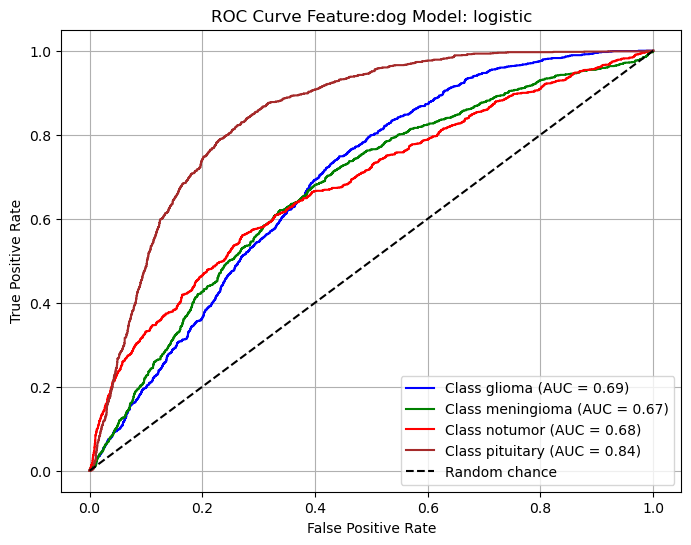

/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


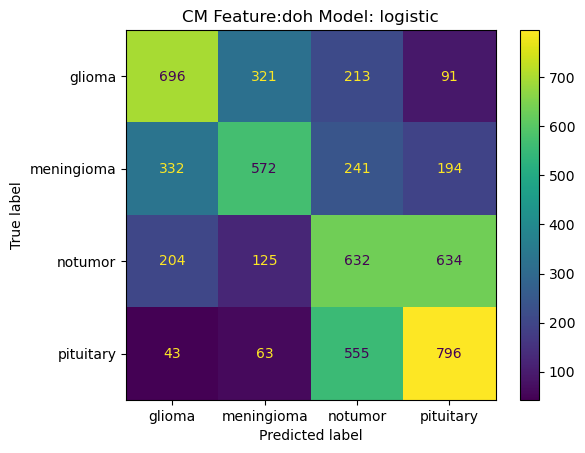

(5712, 4)


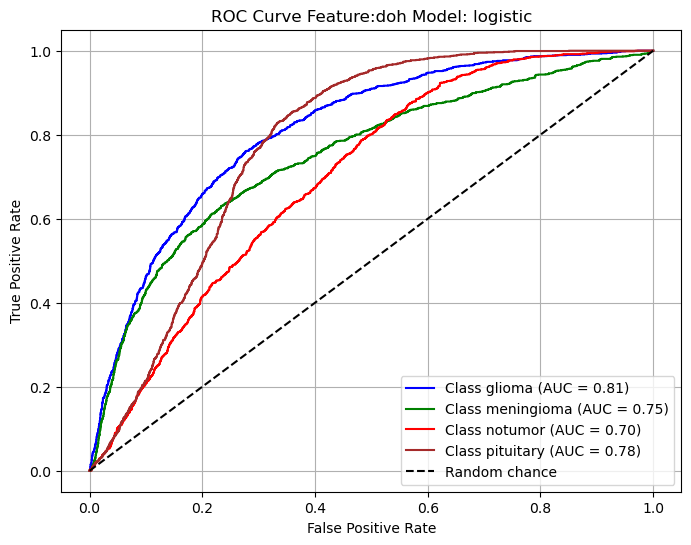

/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


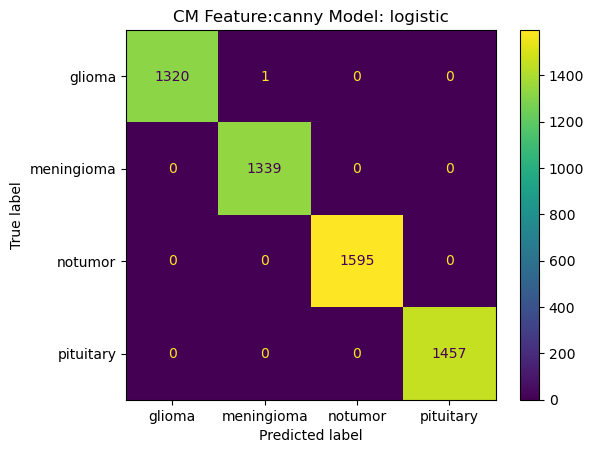

(5712, 4)


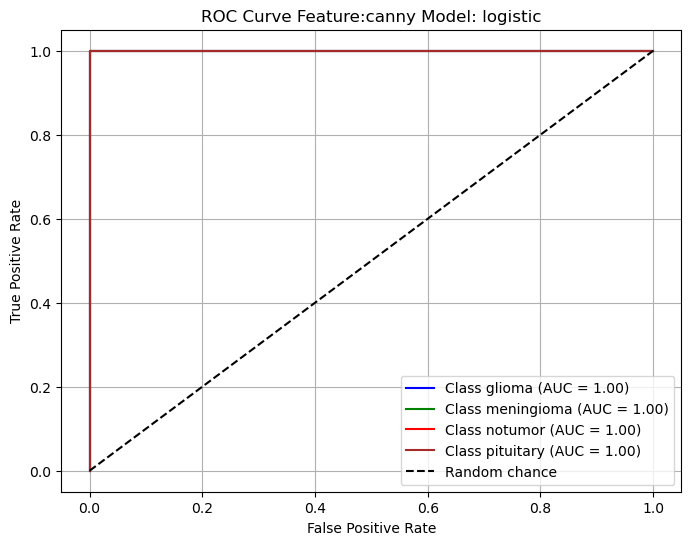

  feature model_type  accuracy_score  macro_precision  macro_recall  macro_f1  \
0     dog   logistic        0.452381         0.439232      0.439812  0.413409   
1     doh   logistic        0.471989         0.481073      0.474156  0.475359   
2   canny   logistic        0.999825         0.999813      0.999811  0.999812   

   micro_precision  micro_recall  micro_f1  training_time  
0         0.452381      0.452381  0.452381       0.222914  
1         0.471989      0.471989  0.471989       0.425688  
2         0.999825      0.999825  0.999825       0.156437  


In [9]:
model_types = ['logistic']
features = {'dog':X_dog_features,
            'doh':X_doh_features,
            'canny':X_canny_features}

all_results = pd.DataFrame(columns = ['feature', 'model_type', 'accuracy_score', 'macro_precision', 'macro_recall', 'macro_f1', 
                                      'micro_precision', 'micro_recall', 'micro_f1', 'training_time'])
model_store = {}

for model_type in model_types:
    for feature in features.keys():
        model, results = train_model(features[feature], y_train, classes=le.classes_, model_type=model_type, feature=feature)
        all_results.loc[len(all_results)] = results
        model_store[str(model_type) + "_" + str(feature)] = model
print(all_results)



### 6. Final Test Evaluation

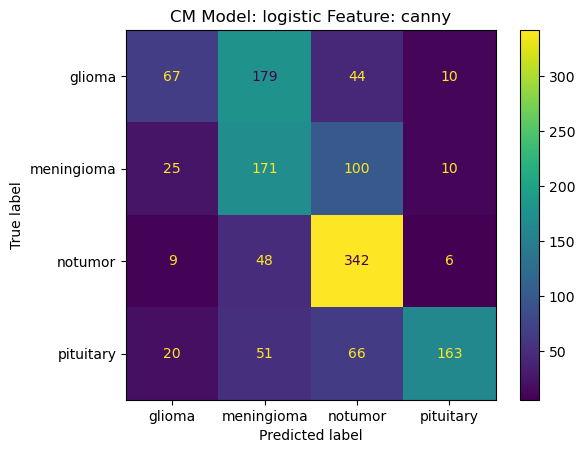

(1311, 4)


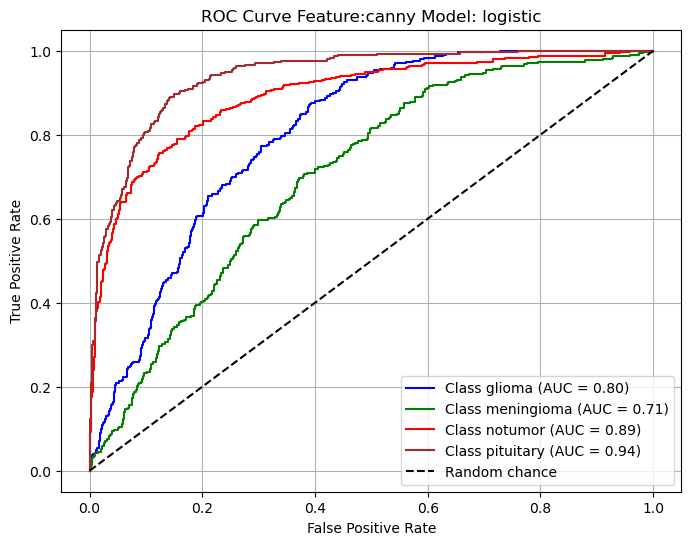

{'feature': 'canny', 'model_type': 'logistic', 'accuracy_score': 0.566742944317315, 'macro_precision': 0.6041411033141668, 'macro_recall': 0.542483660130719, 'macro_f1': 0.5381675319150062, 'micro_precision': 0.566742944317315, 'micro_recall': 0.566742944317315, 'micro_f1': 0.566742944317315, 'inference_time': 0.002856457605957985}


In [11]:

X_test_canny = np.load('X_test_canny.npy')
X_test_doh = np.load('X_test_doh.npy')
X_test_dog = np.load('X_test_dog.npy')
Y_test = np.load('y_test.npy')


result_dict = test_model(model, X_test_canny, Y_test, le.classes_, model_type='logistic', feature='canny')
print(result_dict)

